In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess,
    OUProcess, OUAuxProcess, OUBridgeProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.score_net import ScoreNetSmall, ScoreNet
from neuralbridge.models.neurb import NeuralBridge
from neuralbridge.utils.plotting import plot_sample_path

In [3]:
dim = 1
T = 1.0
dt = 1. / 200
dtype = jnp.float32

gamma = 1.0
sigma = 1.0

seed = 42
u = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

ori_proc = BrownianProcess(gamma, sigma, T, dim, dtype)
aux_proc = BrownianAuxProcess(0.0, sigma, T, dim, dtype)
bridge_proc = BrownianBridgeProcess(gamma, sigma, score_fn=None, v=v, T=T, dim=dim, dtype=dtype)

guided_bridge_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-10,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

In [5]:
neural_net = ScoreNetSmall(
    out_dim=dim,
    hidden_dims=[20, 20, 20, 20],
    norm="batch",
    activation="tanh"
)

# neural_net = ScoreNet(out_dim=dim, 
#               hidden_dims=(32, 64, 32),
#               norm="batch",
#               t_emb_dim=32,
#               t_emb_max_period=50.0,
#               t_emb_scaling=200.0)

In [19]:
train_config = {
    "save_name": "brownian_bridge_differentiable",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 32,
    "n_iters": 5000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 1000
}

In [20]:
neural_bridge = NeuralBridge(
    guided_bridge=guided_bridge_proc,
    neural_net=neural_net,
    train_config=train_config
)

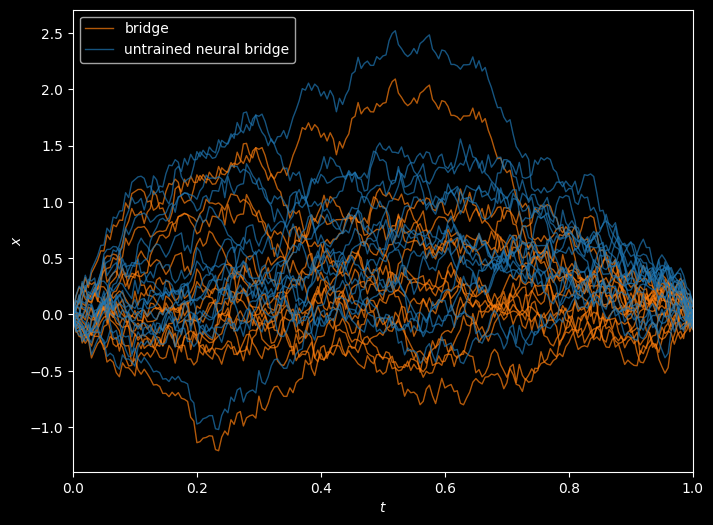

In [21]:
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)
neural_bridge._initialize_optimizer()

bridge_solver = Euler(bridge_proc, wiener_proc)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

neural_bridge_path1 = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(bridge_path, color="tab:orange", ax=ax, label="bridge")
plot_sample_path(neural_bridge_path1, color="tab:blue", ax=ax, label="untrained neural bridge")
plt.show()


In [22]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -17.52737
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_1


Epoch 2:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -63.45825
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_2


Epoch 3:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -101.14877
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_3


Epoch 4:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -133.94221
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_4


Epoch 5:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -161.40262
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_5


Epoch 6:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -183.71527
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_6


Epoch 7:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -200.34911
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_7


Epoch 8:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -211.23520
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_8


Epoch 9:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -216.98262
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_9


Epoch 10:   0%|          | 0/5000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -219.10547
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_differentiable/epoch_10


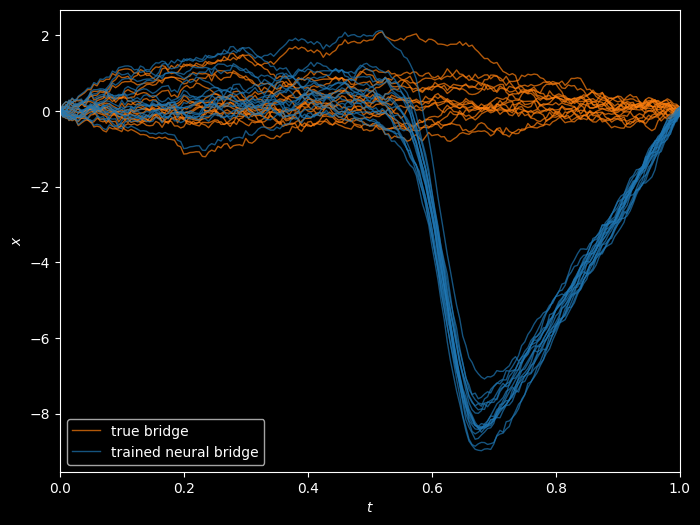

In [23]:
bridge_solver = Euler(bridge_proc, wiener_proc)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(bridge_path, color="tab:orange", ax=ax, label="true bridge")
plot_sample_path(neural_bridge_path, color="tab:blue", ax=ax, label="trained neural bridge")
plt.show()

In [25]:
neural_bridge.neural_net.apply(variables={
    "params": neural_bridge.state.params,
    "batch_stats": neural_bridge.state.batch_stats
}, t=jnp.array([0.2]), x=jnp.array([0.2]), training=False, mutable=False)


Array([0.00071718], dtype=float32)

In [ ]:
neural_bridge.neural_net.apply(variables={

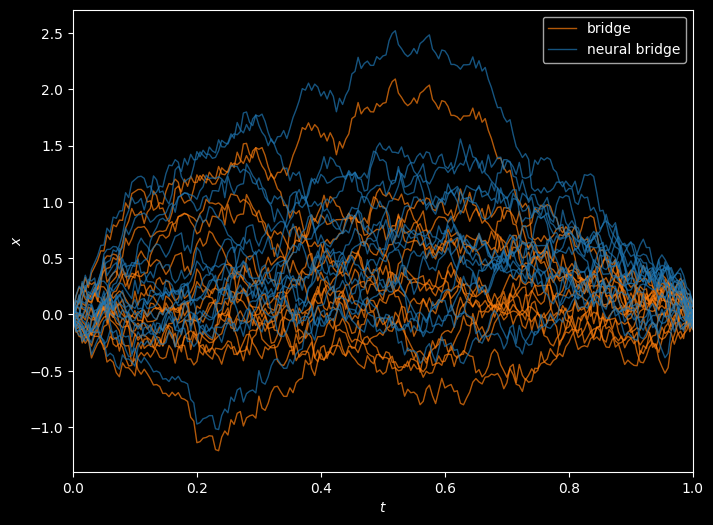

In [17]:
bridge_solver = Euler(bridge_proc, wiener_proc)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(bridge_path, color="tab:orange", ax=ax, label="bridge")
plot_sample_path(neural_bridge_path, color="tab:blue", ax=ax, label="neural bridge")
plt.show()

In [18]:
out = neural_bridge.state.apply_fn(
    variables={
        "params": neural_bridge.state.params,
        "batch_stats": neural_bridge.state.batch_stats
    },
    t=jnp.array([[0.9]]),
    x=jnp.array([[-0.2]]),
    training=False,
    mutable=False
)
print(out)

[[0.00359132]]
